In [1]:
from functools import partial
import logging
from collections import OrderedDict

import numpy as np
from osgeo import gdal
%pylab inline
import matplotlib
import matplotlib.pyplot as plt

import proxmin
from proxmin import nmf
import dc

plogger = logging.getLogger("proxmin")
plogger.setLevel(logging.DEBUG)

Populating the interactive namespace from numpy and matplotlib


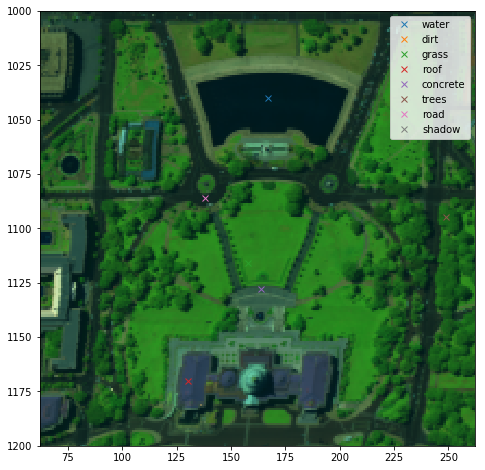

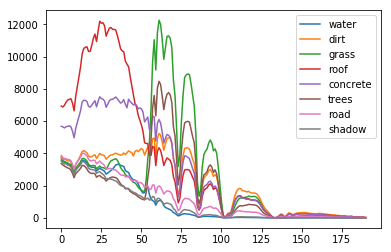

In [38]:
ds = gdal.Open('/Users/fred/Downloads/Hyperspectral_Project/dc.tif')
data_shape = ds.GetRasterBand(1).ReadAsArray().shape

# only use a subset of the image
shape = (ds.RasterCount, data_shape[0]*data_shape[1])
points = dc.ref_points

# Get hyperspectral data
data = np.zeros(shape)
for bidx in range(shape[0]):
    band = ds.GetRasterBand(bidx + 1).ReadAsArray()
    data[bidx] = band.flatten()
dc.plot_color_img(data, data_shape, figsize=(8,8), show=False);

points = OrderedDict([
    ('water', (167, 1040)),
    ('dirt', (132, 272)),
    #('dirt', (207, 1021)),
    ('grass', (158, 1116)),
    #('grass', (166, 1105)),
    ('roof', (130, 1170)),
    #('concrete', (156, 1170)),
    #('concrete', (167, 1023)),
    ('concrete', (164, 1128)),
    #('trees', (249, 1123)),
    ('trees', (249, 1095)),
    #('road', (138, 1086)),
    #('road', (175, 1196)),
    ('road', (138, 1086)),
    ('shadow', (175, 465))
    #('shadow', (70, 1160))
])

spectra = OrderedDict()
for obj, pt in points.items():
    plt.plot(pt[0], pt[1],'x', label=obj)
    spectra[obj] = dc.get_point_spec(pt[0], pt[1], data, data_shape)
plt.legend()
plt.xlim([62,262])
plt.ylim([1200,1000])
plt.show()

for obj, pt in points.items():
    plt.plot(spectra[obj], label=obj)
plt.legend()
plt.show()

# Get wavelengths used in hyperspectral data
wavelength_data = np.recfromcsv('/Users/fred/Downloads/Hyperspectral_Project/wavelengths.txt', delimiter=" ")
wavelength = wavelength_data["wavelength"]
idx = wavelength_data["idx"]

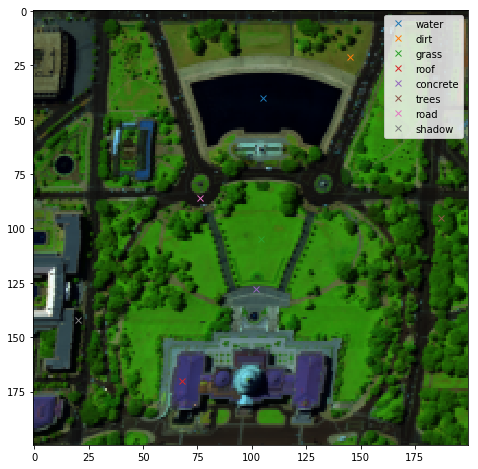

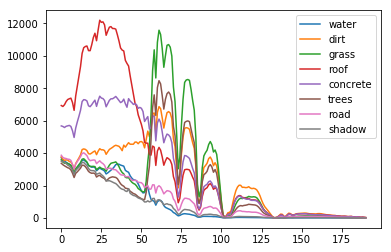

In [39]:
# only use a subset of the image
xmin = 62
xmax = 262
ymin = 1000
ymax = 1200
img_shape = (ymax-ymin, xmax-xmin)
subset = data.reshape(data.shape[0], data_shape[0], data_shape[1])[:,ymin:ymax, xmin:xmax]
subset = subset.reshape(data.shape[0], img_shape[0]*img_shape[1])
dc.plot_color_img(subset, img_shape, show=False)

test_spectra = {}
for obj, pt in dc.ref_points.items():
    plt.plot(pt[0], pt[1],'x', label=obj)
    test_spectra[obj] = dc.get_point_spec(pt[0], pt[1], subset, img_shape)
plt.legend()
plt.show()

for obj, pt in points.items():
    plt.plot(test_spectra[obj], label=obj)
plt.legend()
plt.show()

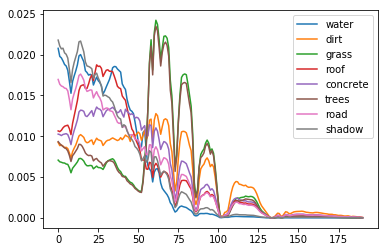

In [40]:
def init_nmf(data, img_shape, points, spec):
    """Initialize A0 and S0 using the reference points
    """
    A0 = np.zeros((data.shape[0], len(points)))
    S0 = np.zeros((len(points), img_shape[0]*img_shape[1]))

    for idx, (obj,(x,y)) in enumerate(points.items()):
        A0[:, idx] = spec[obj]
        S0[idx, y*img_shape[1]+x] = data[idx, y*img_shape[1]+x]
    norm = np.sum(A0, axis=0)
    A0 = A0/norm
    for idx, (obj,(x,y)) in enumerate(points.items()):
        plt.plot(A0[:, idx], label=obj)
    plt.legend()
    plt.show()
    return A0, S0

points = dc.ref_points
#if "shadow" in points:
#    del points["shadow"]
A0,S0 = init_nmf(subset, img_shape, points, spectra)
Ls = [[np.ones((1,A0.shape[0]))], [None]]

prox_A = proxmin.operators.prox_plus
prox_g = [[dc.prox_ones],[proxmin.operators.prox_id]]
#steps_g = [[1e-5],[None]]
#norm_L2 = [[np.array([50])], [1]]

In [41]:
import scipy.sparse
def prox_bkg(X, step, bidx=-1):
    """Use a constant background
    """
    X[bidx] = np.mean(X[bidx])
    return X

def prox_bkg_plus(X, step, bidx=-1):
    X = prox_bkg(X, step, bidx)
    X = proxmin.operators.prox_plus(X, step)
    return X

prox_g = partial(prox_bkg_plus, bidx=-1)

L = float(proxmin.utils.get_spectral_norm(A0))
print(L)
prox_S = partial(proxmin.nmf.prox_likelihood_S, A=A0, Y=subset, prox_g=prox_g)
S0 = proxmin.algorithms.apgm(X0=S0, prox_f=prox_S, step_f=.5/L, max_iter=10)

0.08352305690303014


INFO:proxmin.algorithms:Completed 10 iterations


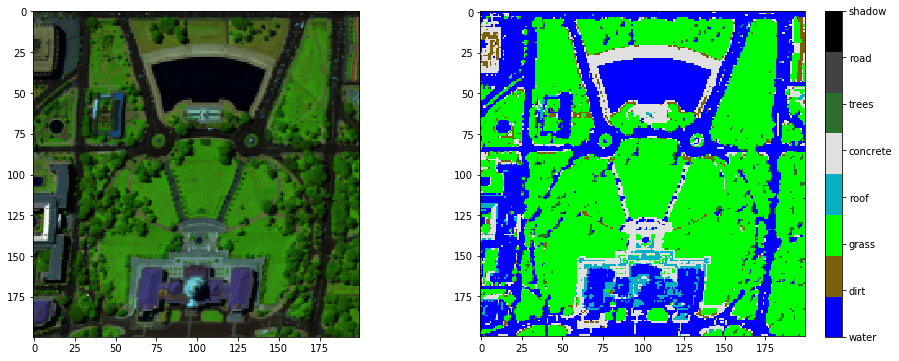

In [42]:
dc.compare_likelihood(subset, img_shape, S0, points, figsize=(16,6))

In [43]:
#Ls = [[None], [scipy.sparse.identity(A0.shape[1])]]
#prox_g = [[dc.prox_ones],[proxmin.operators.prox_id]]


Ls = [[np.ones((1,A0.shape[0]))], [None]]
prox_A = proxmin.operators.prox_plus
prox_S = partial(prox_bkg_plus, bidx=-1)
prox_g = [[dc.prox_ones],[proxmin.operators.prox_id]]

In [44]:
A, S = nmf.nmf(subset,A0, S0,
                     prox_A=prox_A,
                     prox_S=prox_S,
                     Ls=Ls,
                     proxs_g=prox_g,
                     max_iter=1000, 
                     traceback=False,
                     #steps_g=steps_g
                     #norm_L2 = norm_L2
                     #slack=.1
                    )

INFO:proxmin.algorithms:Completed 1001 iterations


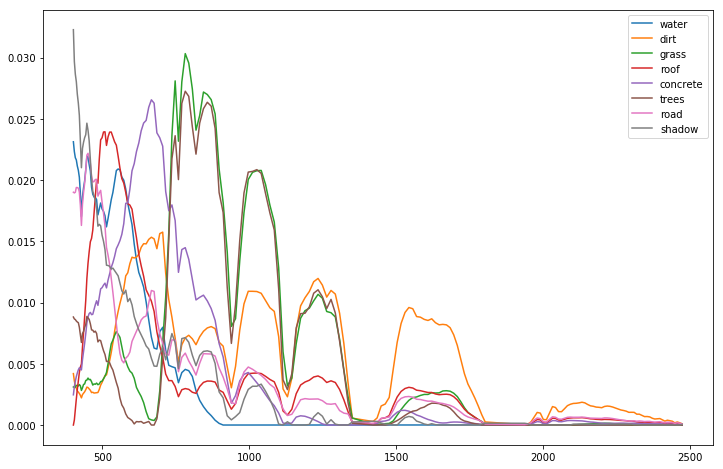

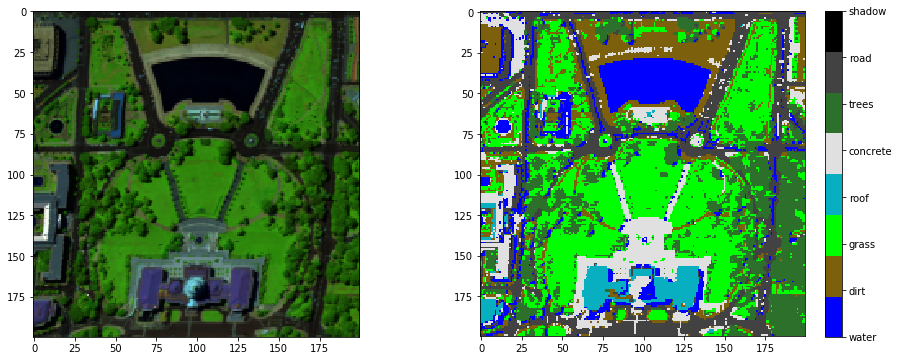

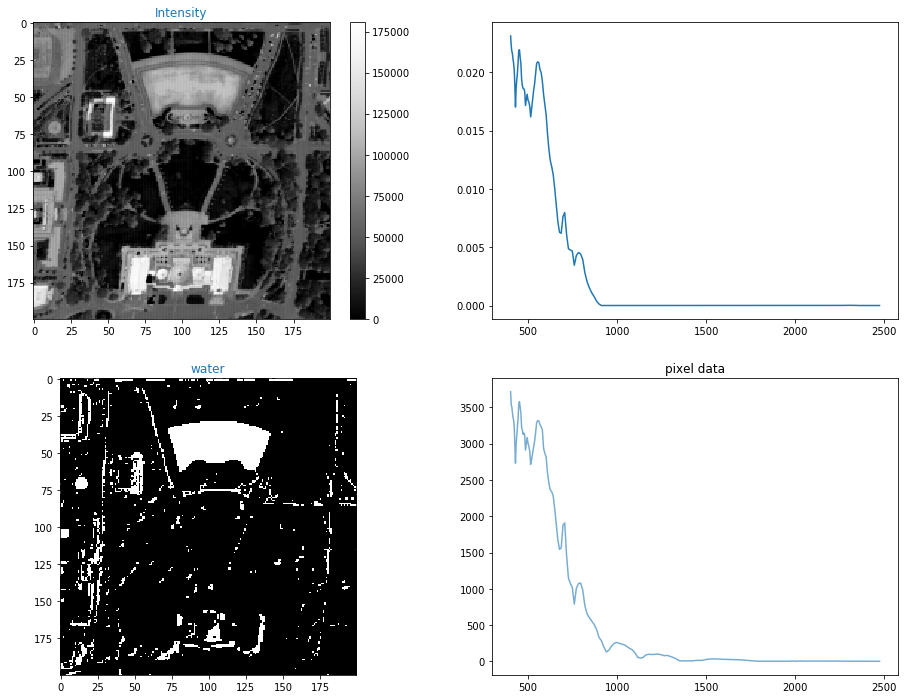

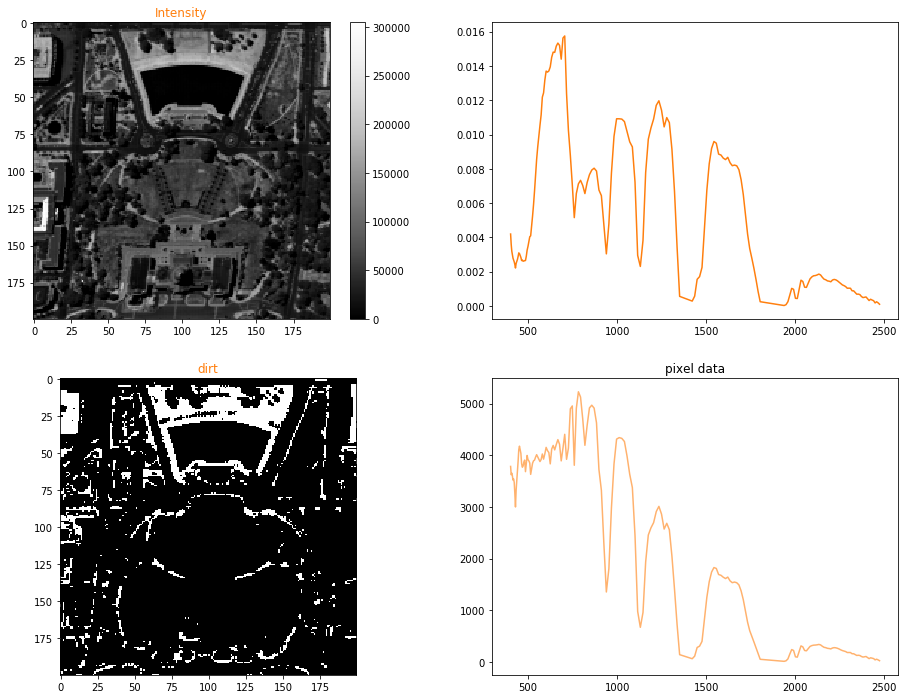

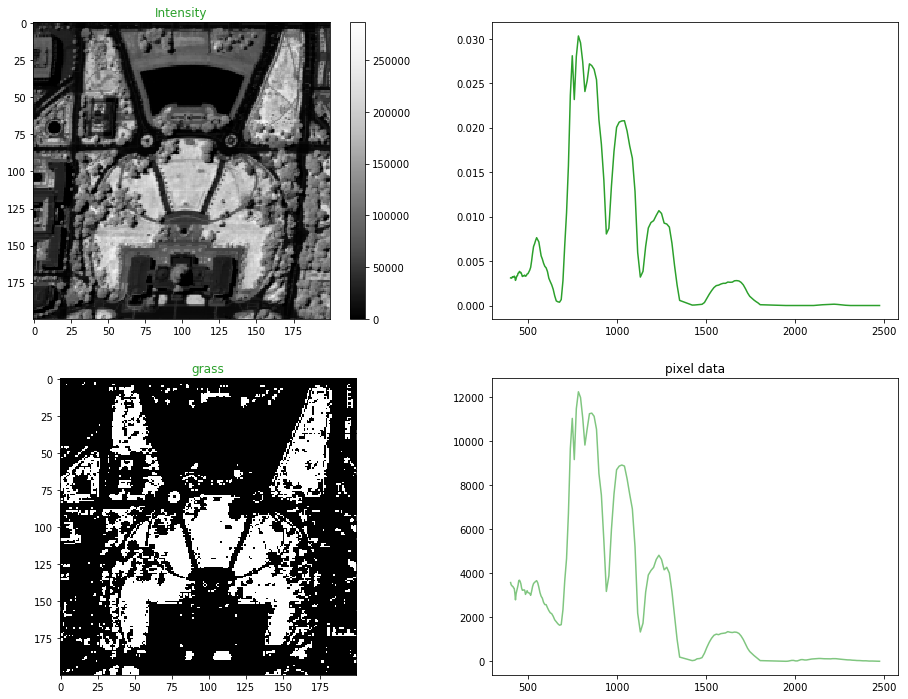

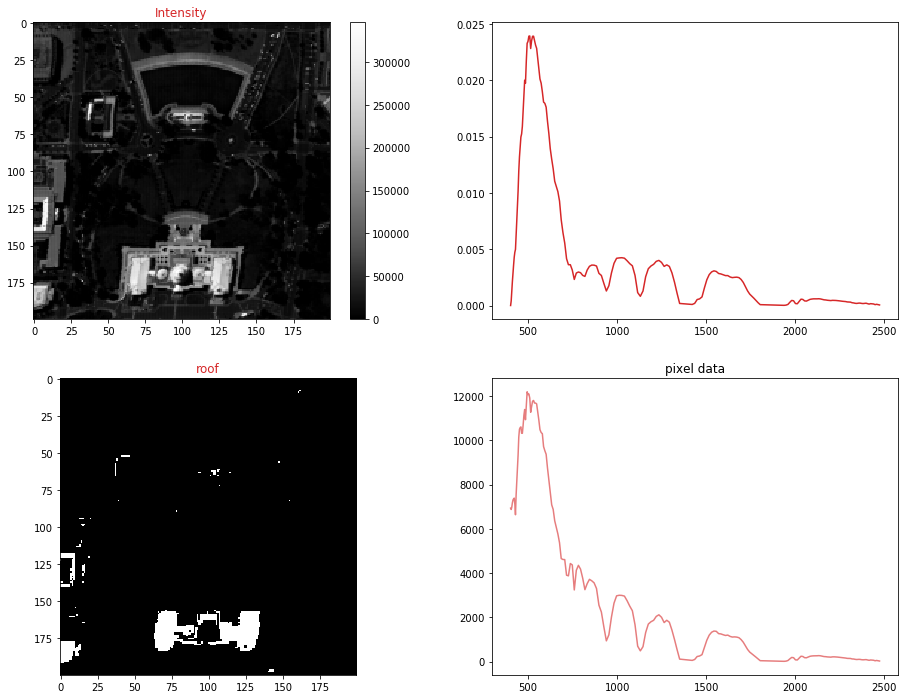

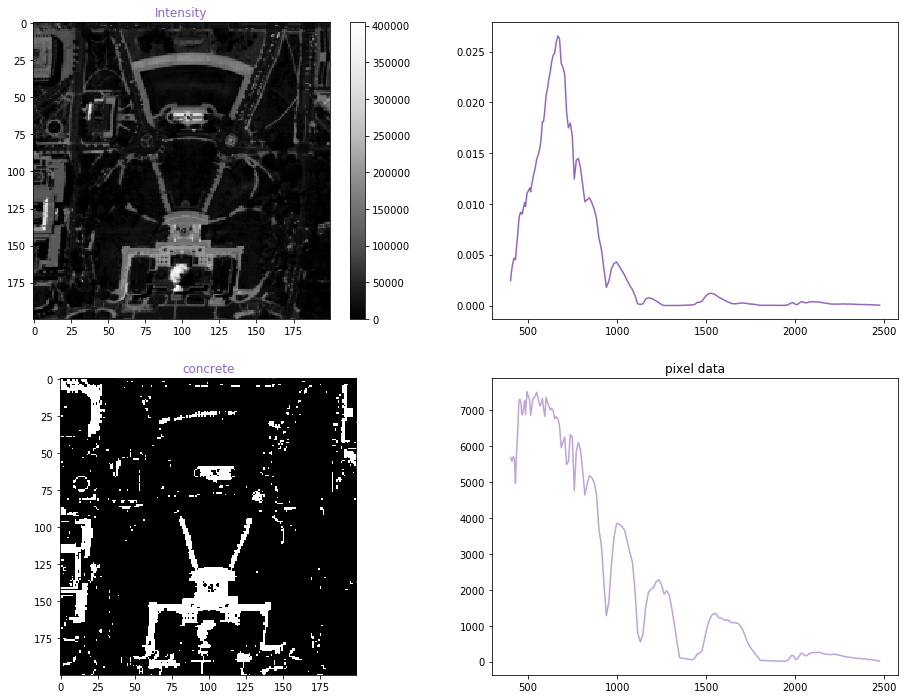

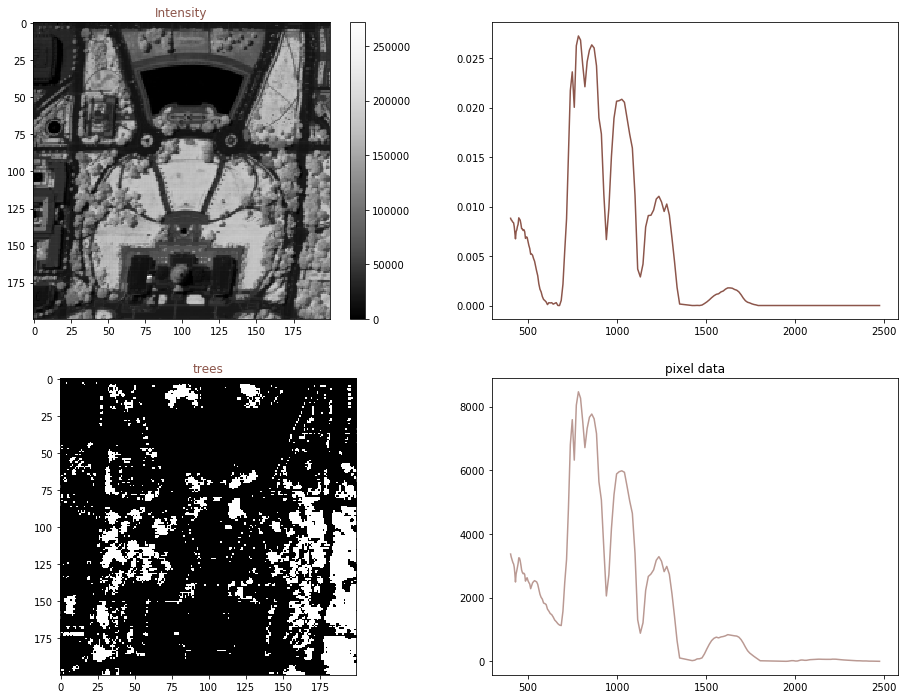

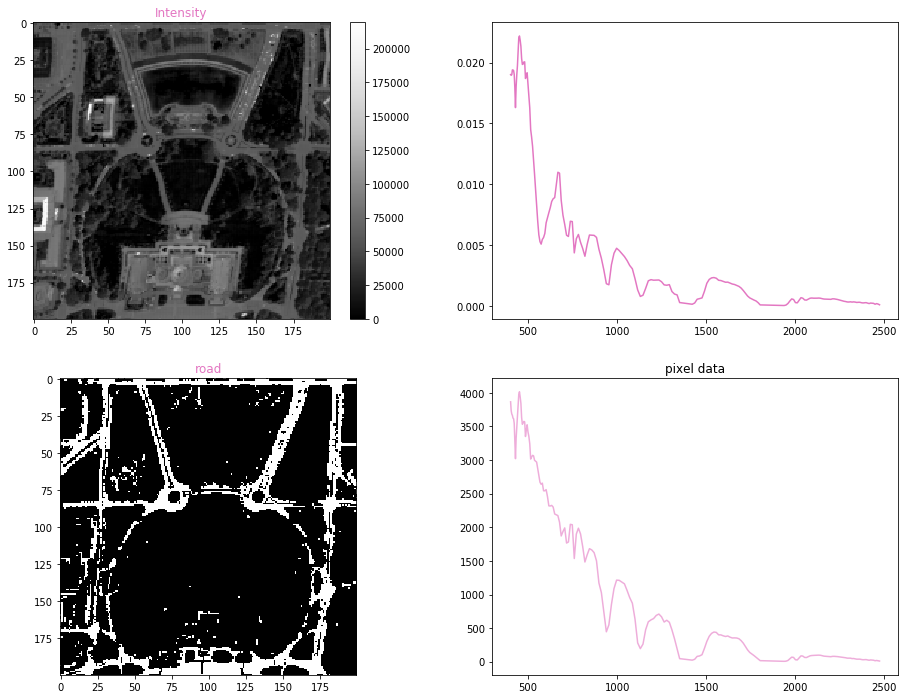

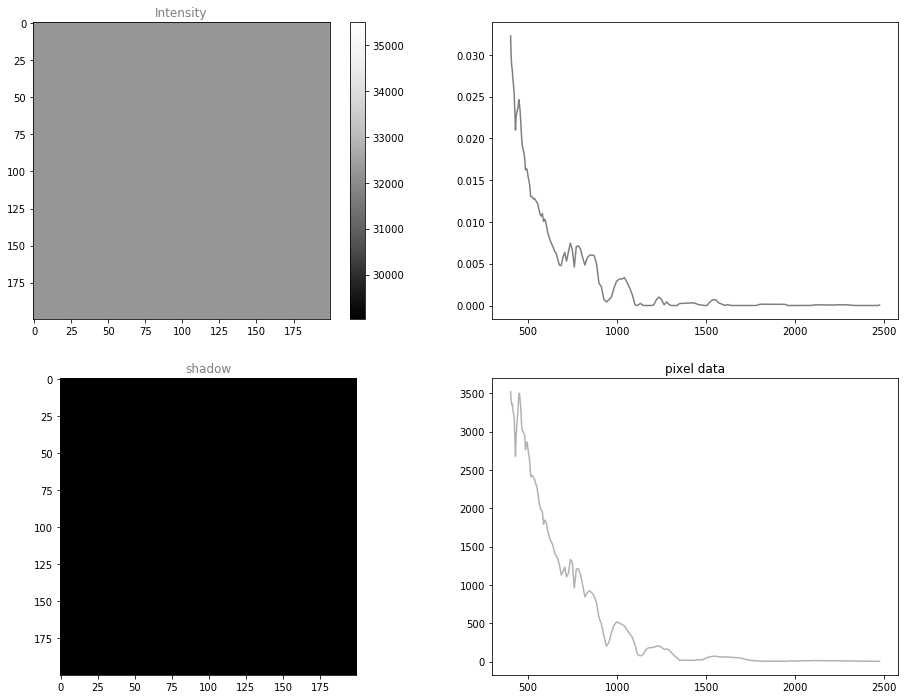

In [45]:
dc.plot_spectra(wavelength, A, points)
dc.compare_likelihood(subset, img_shape, S, points, figsize=(16,6))
dc.plot_objects(subset, A, S, img_shape, points, spectra, wavelength=wavelength)

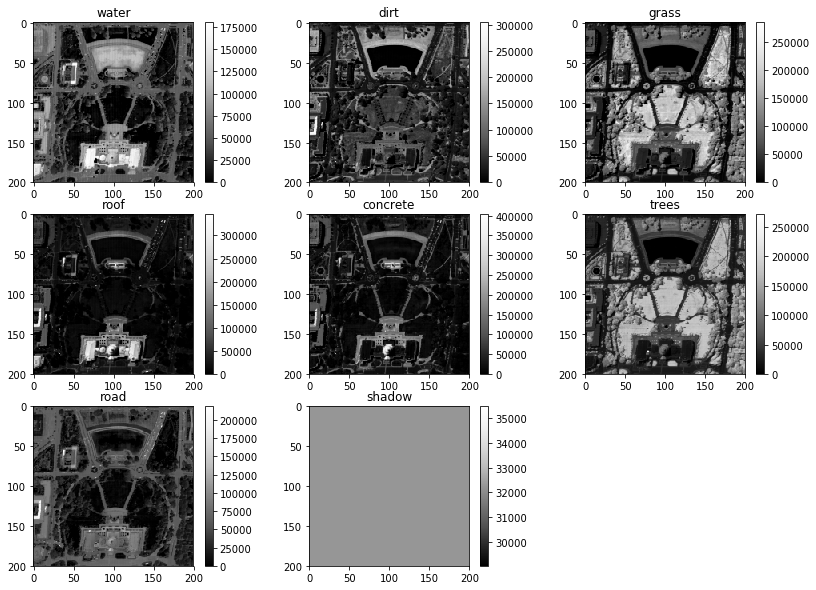

In [46]:
dS = S-S0
fig = plt.figure(figsize=(14,10))
ax = []
for idx, (obj, pt) in enumerate(points.items()):
    ax.append(fig.add_subplot(3,3,idx+1))
    ds = S[idx]
    ax[-1].set_title(obj)
    ax_img = ax[-1].imshow(ds.reshape(img_shape), cmap="Greys_r")
    cbar = fig.colorbar(ax_img, ax=ax[-1])
plt.show()

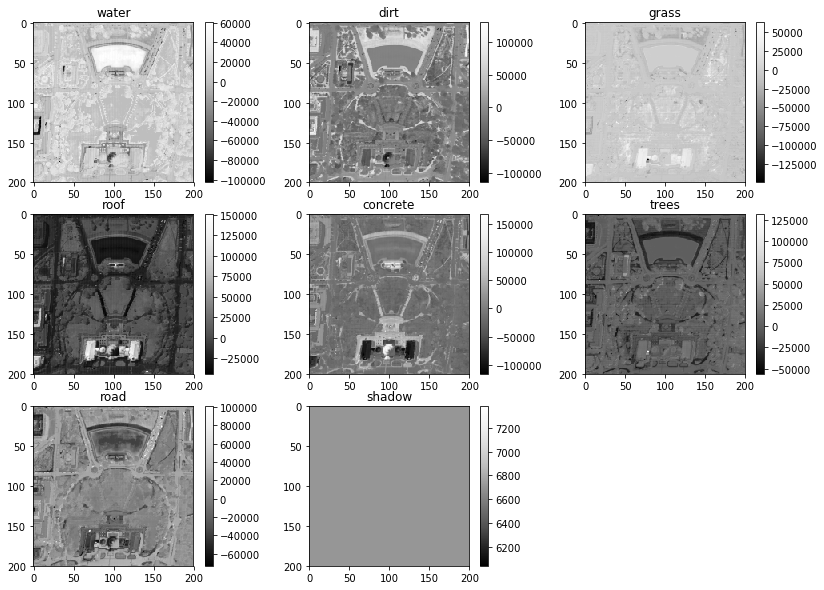

In [16]:
dS = S-S0
fig = plt.figure(figsize=(14,10))
ax = []
for idx, (obj, pt) in enumerate(points.items()):
    ax.append(fig.add_subplot(3,3,idx+1))
    ds = dS[idx]
    ax[-1].set_title(obj)
    ax_img = ax[-1].imshow(ds.reshape(img_shape), cmap="Greys_r")
    cbar = fig.colorbar(ax_img, ax=ax[-1])
plt.show()

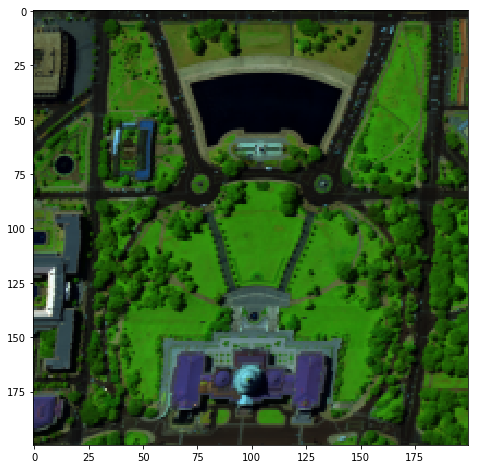

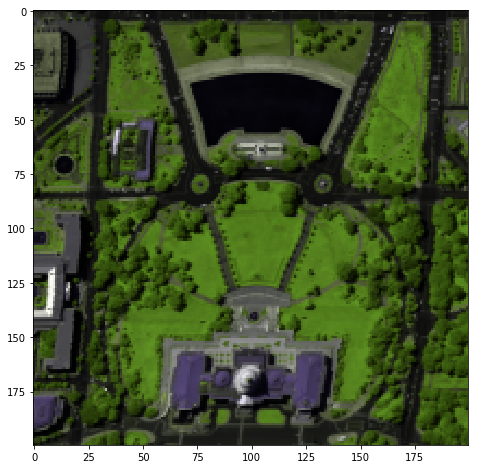

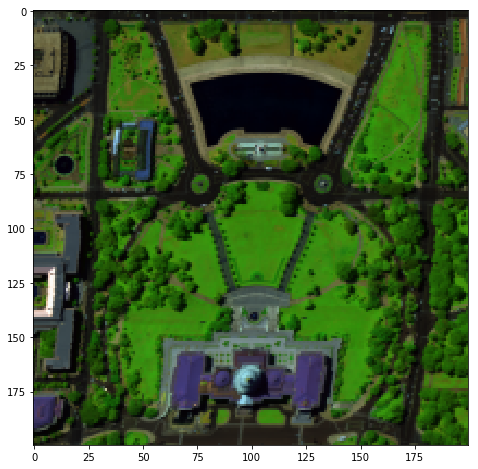

array([[[ 34,  35,  29],
        [ 30,  30,  25],
        [ 30,  30,  25],
        ..., 
        [ 25,  23,  20],
        [ 25,  23,  20],
        [ 26,  25,  21]],

       [[ 42,  46,  35],
        [ 41,  44,  35],
        [ 40,  43,  33],
        ..., 
        [ 28,  27,  20],
        [ 29,  28,  20],
        [ 29,  29,  21]],

       [[ 52,  58,  49],
        [ 46,  51,  43],
        [ 43,  47,  40],
        ..., 
        [ 24,  21,  17],
        [ 24,  20,  17],
        [ 25,  22,  19]],

       ..., 
       [[ 57,  67,  21],
        [ 56,  68,  19],
        [ 42,  66,  13],
        ..., 
        [ 33,  87,   6],
        [ 27,  68,   4],
        [ 27,  72,   5]],

       [[ 32,  52,  11],
        [ 49,  61,  15],
        [ 36,  59,  14],
        ..., 
        [ 38,  86,   9],
        [ 32,  78,   5],
        [ 29,  75,   5]],

       [[ 15,  23,   7],
        [ 16,  23,   9],
        [ 27,  37,  15],
        ..., 
        [ 48, 101,  13],
        [ 39, 100,   7],
        [ 28,  69,

In [24]:
model0 = A0.dot(S0)
model = A.dot(S)
dc.plot_color_img(subset, img_shape)
dc.plot_color_img(model0, img_shape)
dc.plot_color_img(model, img_shape)

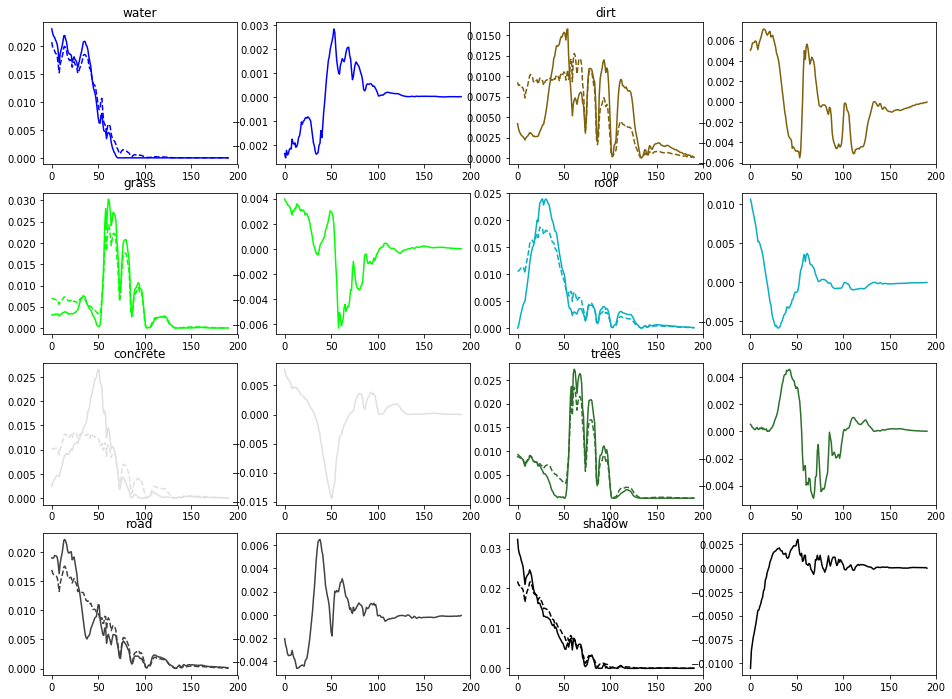

In [23]:
dA = A0-A

fig = plt.figure(figsize=(16,12))
for idx, (obj, pt) in enumerate(points.items()):
    ax1 = fig.add_subplot(4,4,2*idx+1)
    ax2 = fig.add_subplot(4,4,2*idx+2)
    ax1.set_title(obj)
    ax1.plot(A[:,idx], color=dc.ref_colors[obj])
    ax1.plot(A0[:,idx], '--', color=dc.ref_colors[obj])
    ax2.plot(dA[:,idx], color=dc.ref_colors[obj])
plt.show()

In [26]:
import scipy.sparse
def prox_bkg(X, step, bidx=-1):
    """Use a constant background
    """
    X[bidx] = np.mean(X[bidx])
    return X

def prox_bkg_plus(X, step, bidx=-1):
    X = prox_bkg(X, step, bidx)
    X = proxmin.operators.prox_plus(X, step)
    return X

prox_g = partial(prox_bkg_plus, bidx=-1)

L = float(proxmin.utils.get_spectral_norm(A0))
print(L)
prox_S = partial(proxmin.nmf.prox_likelihood_S, A=A0, Y=subset, prox_g=prox_g)
S0 = proxmin.algorithms.apgm(X0=S0, prox_f=prox_S, step_f=.5/L, max_iter=100)

0.08352305690303014


INFO:proxmin.algorithms:Completed 100 iterations


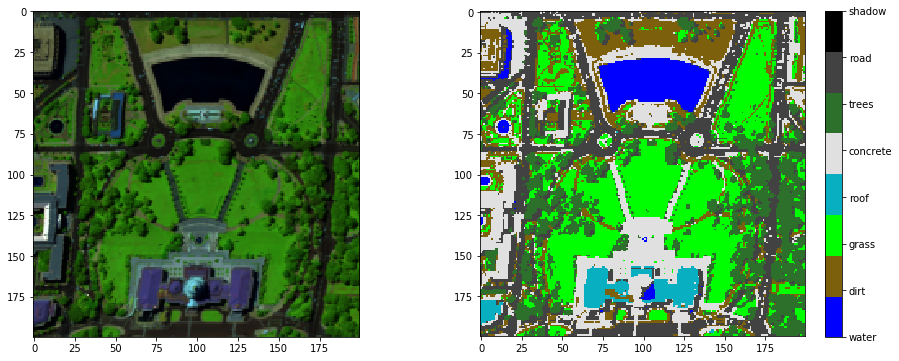

In [27]:
dc.compare_likelihood(subset, img_shape, S0, points, figsize=(16,6))

In [28]:
Ls = [[np.ones((1,A0.shape[0]))], [None]]
prox_A = proxmin.operators.prox_plus
prox_S = partial(prox_bkg_plus, bidx=-1)
prox_g = [[dc.prox_ones],[proxmin.operators.prox_id]]

A, S = nmf.nmf(subset,A0, S0,
                     prox_A=prox_A,
                     prox_S=prox_S,
                     Ls=Ls,
                     proxs_g=prox_g,
                     max_iter=1000, 
                     traceback=False,
                     #steps_g=steps_g
                     #norm_L2 = norm_L2
                     #slack=.1
                    )

INFO:proxmin.algorithms:Completed 1001 iterations


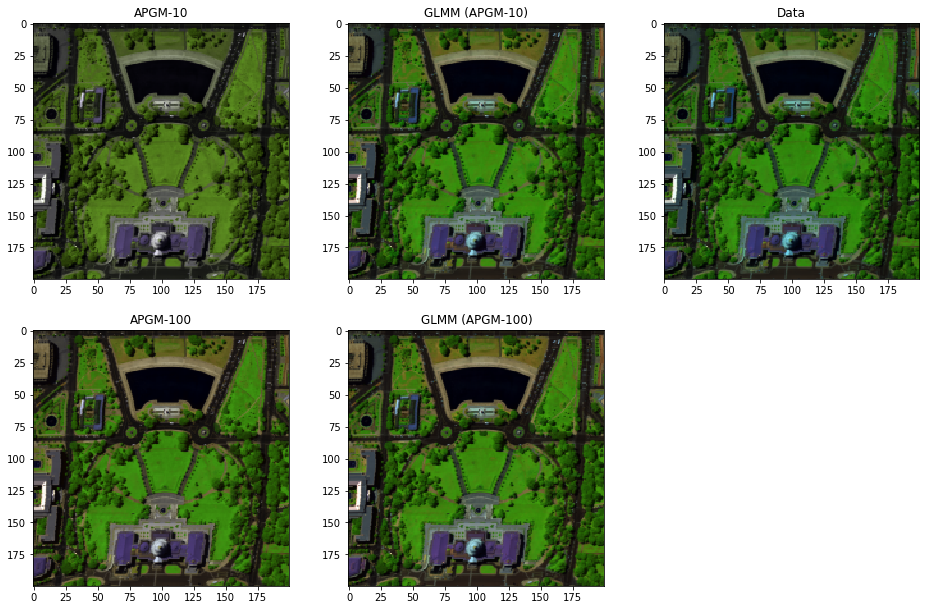

In [36]:
fig = plt.figure(figsize=(16,16))
ax = [fig.add_subplot(3,3,idx+1) for idx in range(5)]

ax[2].set_title("Data")
dc.plot_color_img(subset, img_shape, show=False, ax=ax[2])
ax[0].set_title("APGM-10")
dc.plot_color_img(model0, img_shape, show=False, ax=ax[0])
ax[1].set_title("GLMM (APGM-10)")
dc.plot_color_img(model, img_shape, show=False, ax=ax[1])
ax[3].set_title("APGM-100")
dc.plot_color_img(_model0, img_shape, show=False, ax=ax[3])
ax[4].set_title("GLMM (APGM-100)")
dc.plot_color_img(_model, img_shape, show=False, ax=ax[4])

plt.show()

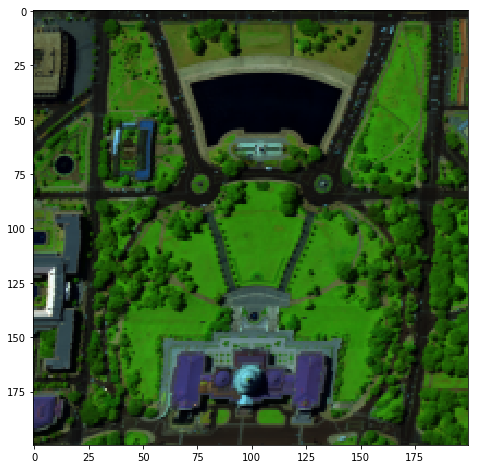

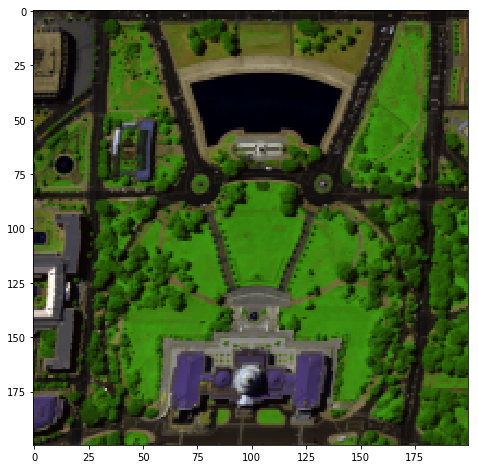

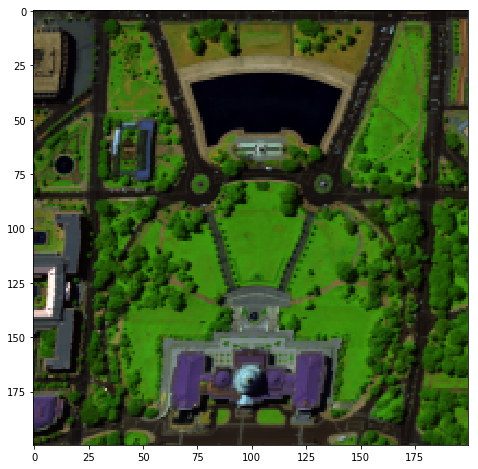

array([[[ 38,  34,  29],
        [ 34,  29,  25],
        [ 34,  30,  25],
        ..., 
        [ 27,  23,  20],
        [ 28,  23,  20],
        [ 29,  24,  21]],

       [[ 45,  45,  35],
        [ 44,  44,  35],
        [ 43,  42,  33],
        ..., 
        [ 32,  27,  20],
        [ 33,  28,  20],
        [ 33,  28,  21]],

       [[ 55,  58,  49],
        [ 49,  51,  43],
        [ 47,  46,  40],
        ..., 
        [ 27,  21,  17],
        [ 26,  20,  17],
        [ 27,  22,  19]],

       ..., 
       [[ 62,  66,  21],
        [ 62,  68,  19],
        [ 47,  66,  13],
        ..., 
        [ 36,  86,   6],
        [ 29,  68,   4],
        [ 30,  72,   5]],

       [[ 35,  52,  11],
        [ 55,  60,  15],
        [ 40,  59,  14],
        ..., 
        [ 42,  86,   9],
        [ 34,  77,   5],
        [ 32,  75,   5]],

       [[ 17,  23,   7],
        [ 18,  22,   9],
        [ 30,  37,  15],
        ..., 
        [ 53, 101,  13],
        [ 42,  99,   7],
        [ 30,  69,

In [29]:
_model0 = A0.dot(S0)
_model = A.dot(S)
dc.plot_color_img(subset, img_shape)
dc.plot_color_img(_model0, img_shape)
dc.plot_color_img(_model, img_shape)

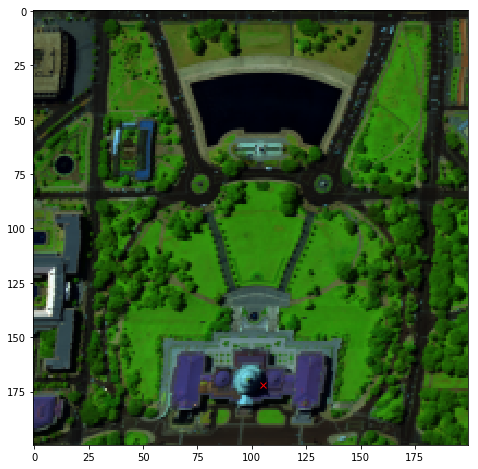

In [101]:
dc.plot_color_img(subset, img_shape, figsize=(8,8), show=False);
plt.plot(105, 172, 'rx')

In [114]:
points.keys()

odict_keys(['water', 'dirt', 'grass', 'roof', 'concrete', 'trees', 'road', 'shadow'])

In [113]:
S[:,sidx]

array([ 73135.47521928,      0.        ,      0.        ,   3381.36530239,
            0.        ,      0.        ,  66595.87000447,  32263.13611427])

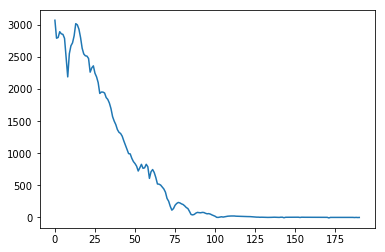

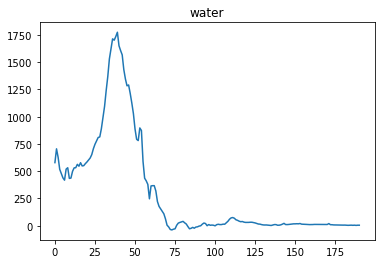

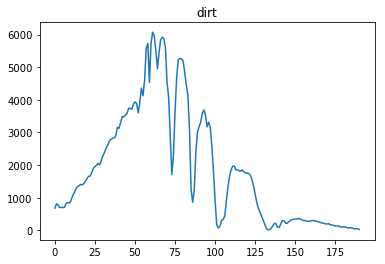

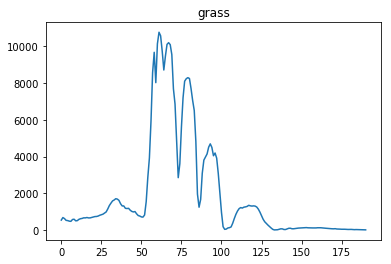

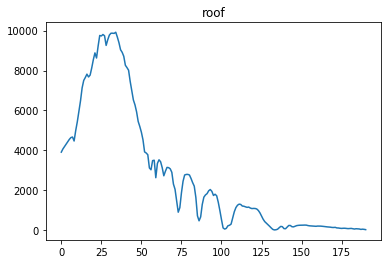

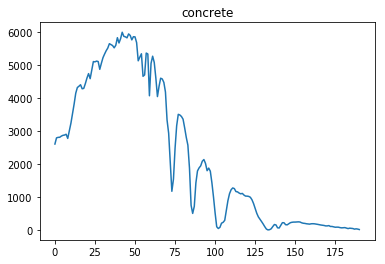

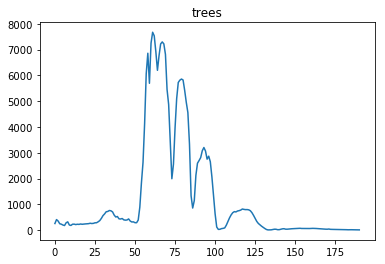

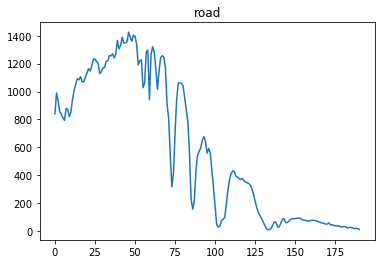

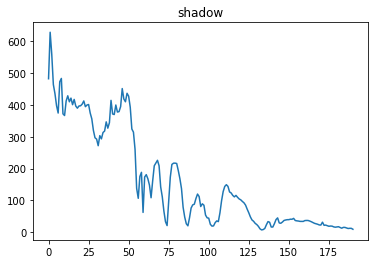

In [128]:
minspec = np.min(subset, axis=1)
plt.plot(minspec)
plt.show()

for idx, (obj, (ox, oy)) in enumerate(points.items()):
    pidx = oy*img_shape[1]+ox
    plt.title(obj)
    plt.plot(model[:,pidx]-minspec)
    plt.show()

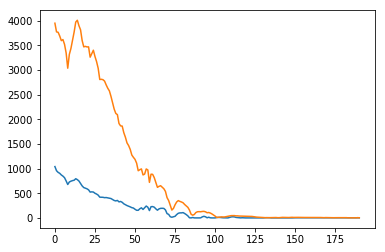

In [119]:
tx = 105
ty = 172
sidx = ty*img_shape[1]+tx
plt.plot(A[:,-1]*S[-1,sidx])
plt.plot(subset[:, sidx])

In [51]:
widx = list(points.keys()).index("water")
ridx = list(points.keys()).index("road")

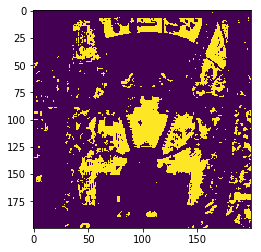

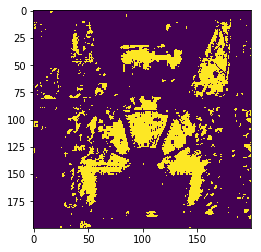

In [56]:
plt.imshow((S[widx]<10000).reshape(img_shape))
plt.show()
plt.imshow((S[ridx]<10000).reshape(img_shape))
plt.show()

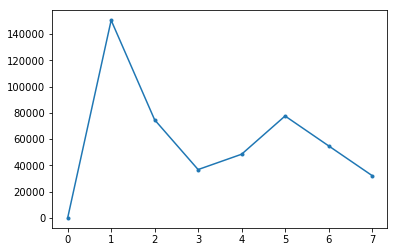

In [72]:
dx, dy = points["dirt"]
didx = dy*img_shape[1]+dx

plt.plot(S[:,didx], '.-')

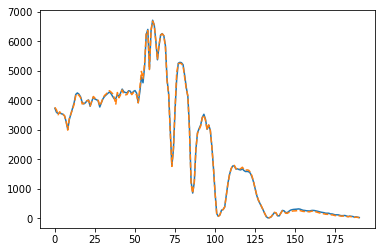

In [75]:
plt.plot(model[:,didx+3])
plt.plot(subset[:,didx+3], '--')

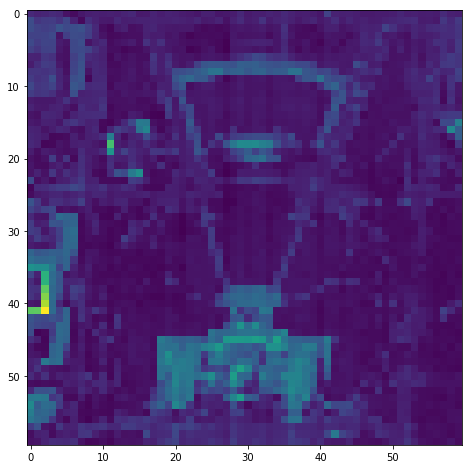

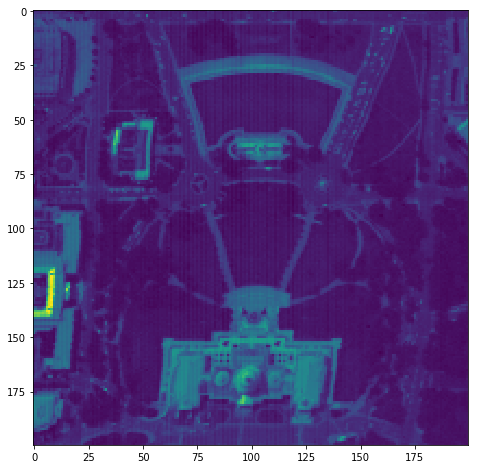

In [89]:
from scipy.ndimage import zoom

s_img = subset[0].reshape(img_shape)
plt.figure(figsize=(8,8))
plt.imshow(zoom(s_img, .3))
plt.show()

plt.figure(figsize=(8,8))
plt.imshow(s_img)
plt.show()